# Predicting countries' covid indicators using LSTM RNNs
Includes preprocessing data from ourworldindata, design and training of a RNN using tf.keras, and visualization of predicted results

Juan Andrés Toro
2021-04-10

# Setup

In [ ]:
# Get and unzip models
!wget https://github.com/juan-td/covid-ml-project/raw/main/window_lstm.zip
!unzip window_lstm.zip -d window_lstm

#Import libraries
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import plotly.graph_objects as go
import datetime
import os

--2021-04-15 16:22:02--  https://github.com/juan-td/covid-ml-project/raw/main/window_lstm.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/juan-td/covid-ml-project-lstm/raw/main/window_lstm.zip [following]
--2021-04-15 16:22:02--  https://github.com/juan-td/covid-ml-project-lstm/raw/main/window_lstm.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juan-td/covid-ml-project-lstm/main/window_lstm.zip [following]
--2021-04-15 16:22:02--  https://raw.githubusercontent.com/juan-td/covid-ml-project-lstm/main/window_lstm.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... c

In [ ]:
# import covid csv from https://covid.ourworldindata.org/data/owid-covid-data.csv
covid_data_df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
covid_data_df.sample(5)

iso_code      continent  ... life_expectancy human_development_index
73895      TLS           Asia  ...           69.50                   0.606
36975      ITA         Europe  ...           83.51                   0.892
47591      MEX  North America  ...           75.05                   0.779
5138       AZE           Asia  ...           73.00                   0.756
73603      THA           Asia  ...           77.15                   0.777

[5 rows x 59 columns]

# Data preprocessing
- Choose which column to base predictions on (known as pred_column), new cases or deaths
- Select columns relevant to preprocessing (date, country iso_code, location, pred_column) between 2020-05-1 and two days ago
- Describe and plot the pred_column
- Group data by country and create a pd.df for each country
- Impute NaNs with the median value for each country and negative values with 0
- Plot the pred_column again for all countries and for each country
- Remove countries where the majority of values are zero or have less reports than the USA (in order to keep consistent number of rows)
- Standardize data with global mean and std dev
- Convert data into np.array
- Define preprocessing function in order to prepare data for prediction


count    68049.000000
mean        81.104732
std        155.985894
min       -276.825000
25%          1.634000
50%         12.927000
75%         86.996000
max       2648.773000
Name: new_cases_smoothed_per_million, dtype: float64





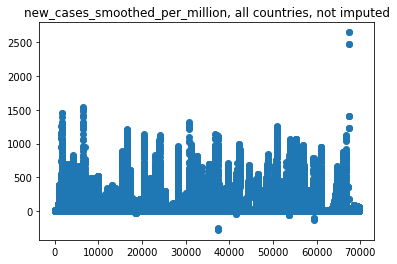

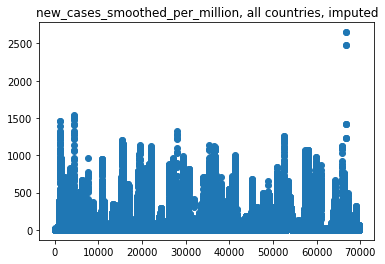

In [ ]:
#choose column on which to base prediction
pred_column = 'new_cases_smoothed_per_million'

#select columns relevant to prediction (date,country iso code, pred_column)
covid_pred_columns_all_countries = covid_data_df[['date','iso_code','location',pred_column]]
covid_pred_columns_all_countries = covid_pred_columns_all_countries[(covid_pred_columns_all_countries['date']>='2020-05-01') & (covid_pred_columns_all_countries['date']< datetime.date.today().strftime('%Y-%m-%d'))]
covid_pred_columns_all_countries.sample(3)

# describe selected data
print(covid_pred_columns_all_countries[pred_column].describe())
print('\n\n')

# plot selected data
plt.scatter(range(covid_pred_columns_all_countries.shape[0]),covid_pred_columns_all_countries[pred_column])
plt.title(pred_column + ', all countries, not imputed')
plt.show()
print('\n\n')

#group by and generate a df for each distinct counry iso code
countries_dfs = [x for _,x in covid_pred_columns_all_countries.groupby('iso_code')]

#replace values lower than 0 with 0 and NaNs with the median
for i in range(len(countries_dfs)):
  country_med = countries_dfs[i][pred_column].median()
  countries_dfs[i][pred_column]=countries_dfs[i][pred_column].fillna(country_med)
  countries_dfs[i][pred_column]=countries_dfs[i][pred_column].apply(lambda x: x if x > 0 else 0)


# combine all countries (now imputed, constrained, and standardized)
covid_pred_columns_all_countries = pd.concat([x for x in countries_dfs])

# plot all dfs again
plt.scatter(range(covid_pred_columns_all_countries.shape[0]),covid_pred_columns_all_countries[pred_column])
plt.title(pred_column + ', all countries, imputed')
plt.show()

# plot by countries
fig = go.Figure()

for i in range(len(countries_dfs)):
  fig.add_trace(go.Scatter(x=countries_dfs[i]['date'],y=countries_dfs[i][pred_column], name=countries_dfs[i]['location'].iloc[0]))

fig.update_layout(
      title = pred_column + ' for individual countries',
      xaxis_title = 'date',
      yaxis_title = pred_column,
)
fig.show()

In [ ]:
# Remove countries with mostly 0 new cases per day and keep only the ones which have the same number of rows
print('Total countries:', len(countries_dfs))
row_count_USA = covid_pred_columns_all_countries['iso_code'][covid_pred_columns_all_countries['iso_code']=='USA'].count()

ilist = []
for i in range(len(countries_dfs)):
  if (countries_dfs[i][pred_column][countries_dfs[i][pred_column]==0].count() > countries_dfs[i].shape[0]*0.3) or (countries_dfs[i][pred_column].count() != row_count_USA):
    ilist.append(i)

countries_dfs = [countries_dfs[i] for i in range(len(countries_dfs)) if i not in ilist]

print('Countries meeting requirements:', len(countries_dfs))

# standardize data
covid_pred_columns_all_countries_std = pd.concat([x for x in countries_dfs])
covid_countries_mean = float(covid_pred_columns_all_countries.mean())
covid_countries_std = float(covid_pred_columns_all_countries.std())

for i in range(len(countries_dfs)):
  countries_dfs[i][pred_column] = (countries_dfs[i][pred_column]-covid_countries_mean)/covid_countries_std

# Convert country dataframes into np arrays
countries_np = []
for i in range(len(countries_dfs)):
  countries_np.append(countries_dfs[i][pred_column].to_numpy())
countries_np=np.array(countries_np)
countries_np=countries_np.reshape(countries_np.shape[0],countries_np.shape[1],1)

# plot by countries
fig = go.Figure()

for i in range(len(countries_dfs)):
  fig.add_trace(go.Scatter(x=countries_dfs[i]['date'],y=countries_dfs[i][pred_column], name=countries_dfs[i]['location'].iloc[0]))

fig.update_layout(
      title = pred_column + ' for individual countries',
      xaxis_title = 'date',
      yaxis_title = pred_column,
)
fig.show()

Total countries: 215
Countries meeting requirements: 183


In [ ]:
# Define preprocessing function for predicting
def preprocess(df_csv, country_name):
  country_csv = df_csv[(df_csv['iso_code']==country_name) & (df_csv['date']>'2020-05-01') & (df_csv['date'] <= datetime.date.today().strftime('%Y-%m-%d'))]
  country_df = (country_csv[pred_column]-covid_countries_mean)/covid_countries_std
  return np.array(country_df).reshape(1,-1,1), country_csv['date'].to_numpy()

In [ ]:
#split into test-validation
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(countries_np, test_size=0.2, random_state=65)

# LSTM training and validation
- Choose how many steps forward the RNN is to predict (pred_amount)
- Split country_np into train and test data
- Generate input (X) and output (y) arrays, where X is the data sequence up until the last pred_amount steps and y is the remaining pred_amount steps
- Define a baseline MSE which is just repeating the last pred_amount steps in the series
- Define a RNN with one 1D-convolutional layer and three LSTM layers which output to a dense layer of size pred_amount
- Train the RNN with train data and validate with test data
- Make and graph predictions using the trained model

In [ ]:
# How many steps to predict
pred_amount = 15

#split into X and Y
X_train = train_set[:,:-pred_amount]; y_train = train_set[:,-pred_amount:,0]
X_test = test_set[:,:-pred_amount]; y_test = test_set[:,-pred_amount:,0]

print(X_train.shape, y_test.shape)

(146, 330, 1) (37, 15)


In [ ]:
# MSE by just predicting the last value
y_pred=X_test[:,-pred_amount:,0]
print(np.mean(keras.losses.mean_squared_error(y_test,y_pred)))

0.6815841710625145


In [ ]:
#RNN architecture and training
model=keras.models.Sequential([
                               keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
                               keras.layers.LSTM(40, return_sequences=True),
                               keras.layers.LSTM(40, return_sequences=True),
                               keras.layers.LSTM(40),
                               keras.layers.Dense(pred_amount)
])
model.compile(optimizer='adam',loss='mse')
history = model.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),batch_size=4,callbacks=[keras.callbacks.ReduceLROnPlateau(factor=0.5), keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)])

print(np.mean(keras.losses.mean_squared_error(y_test,model.predict(X_test))))

Epoch 1/150
42/42 [==============================] - 14s 192ms/step - loss: 1.1704 - val_loss: 1.0902
Epoch 2/150
42/42 [==============================] - 7s 170ms/step - loss: 0.5073 - val_loss: 0.5929
Epoch 3/150
42/42 [==============================] - 7s 174ms/step - loss: 0.4642 - val_loss: 0.4437
Epoch 4/150
42/42 [==============================] - 7s 172ms/step - loss: 0.2840 - val_loss: 0.2946
Epoch 5/150
42/42 [==============================] - 7s 173ms/step - loss: 0.2530 - val_loss: 0.2049
Epoch 6/150
42/42 [==============================] - 7s 176ms/step - loss: 0.2805 - val_loss: 0.2608
Epoch 7/150
42/42 [==============================] - 7s 177ms/step - loss: 0.2484 - val_loss: 0.1866
Epoch 8/150
42/42 [==============================] - 8s 179ms/step - loss: 0.1337 - val_loss: 0.1629
Epoch 9/150
42/42 [==============================] - 7s 176ms/step - loss: 0.1775 - val_loss: 0.1409
Epoch 10/150
42/42 [==============================] - 7s 179ms/step - loss: 0.2215 - val_l

In [ ]:
# Get country's covid stats standardized
country_code='COL'
country_pop = covid_data_df[covid_data_df['iso_code']==country_code]['population'].iloc[0]/1e6
country_pred_covid = preprocess(covid_data_df, country_code)
country_pred_covid_lastfew = (model.predict(country_pred_covid[:,:-pred_amount,:]).reshape(-1)*covid_countries_std+covid_countries_mean)*country_pop
country_pred_covid_nextfew = (model.predict(country_pred_covid).reshape(-1)*covid_countries_std+covid_countries_mean)*country_pop

In [ ]:
#plot preds
x_plot = countries_dfs[0]['date'].to_numpy()
x_plot = np.append(x_plot, pd.date_range(start=x_plot[-1], periods=pred_amount).strftime('%Y-%m-%d'))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_plot,y=(country_pred_covid.reshape(-1)*covid_countries_std+covid_countries_mean)*country_pop, name='real'))
fig.add_trace(go.Scatter(x=x_plot[-2*pred_amount:],y=country_pred_covid_lastfew,name='last '+str(pred_amount)+' days'))
fig.add_trace(go.Scatter(x=x_plot[-pred_amount:],y=country_pred_covid_nextfew, name='next '+str(pred_amount)+' days'))

fig.show()

In [ ]:
# Predict n future intervals
covid_sequence = preprocess(covid_data_df, country_code)
n = 10
for i in range(n):
  preds_n = model.predict(covid_sequence).reshape(1,-1,1)
  covid_sequence = np.append(covid_sequence,preds_n,axis=1)

In [ ]:
# Plot future predictions
fig = go.Figure()
fig.add_trace(go.Scatter(y=covid_sequence.reshape(-1)))
fig.show()

# Window based LSTM 
- Concatenate all countries to generate train and test sequences using Keras' TimeSeriesGenerator
- Select number of days to look back
- Train LSTM network (this time without the convolutional layer)
- predict previous and future points and plot results

In [ ]:
look_back = 30

train_set_concat = train_set.reshape(-1,1)
test_set_concat = test_set.reshape(-1,1)

train_sequence = keras.preprocessing.sequence.TimeseriesGenerator(
    train_set_concat,
    train_set_concat,
    length=look_back,
    batch_size=128
)

test_sequence = keras.preprocessing.sequence.TimeseriesGenerator(
    test_set_concat,
    test_set_concat,
    length=look_back,
    batch_size=16
)


In [ ]:
#RNN architecture and training
if os.path.exists('/content/window_lstm/'):
  model = keras.models.load_model('/content/window_lstm')

else:
  model=keras.models.Sequential([
                               keras.layers.LSTM(40, return_sequences=True),
                               keras.layers.LSTM(40),
                               keras.layers.Dense(1)
  ])

In [ ]:
#If you loaded the model you don't have to train it but you can if you want to
model.compile(optimizer='adam',loss='mse')
history = model.fit(train_sequence,epochs=100,validation_data=test_sequence,callbacks=[keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5), keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)])
model.save('window_lstm')

Epoch 1/100
398/398 [==============================] - 7s 12ms/step - loss: 0.0149 - val_loss: 0.0230
Epoch 2/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0182 - val_loss: 0.0217
Epoch 3/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0153 - val_loss: 0.0213
Epoch 4/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0158 - val_loss: 0.0231
Epoch 5/100
398/398 [==============================] - 5s 11ms/step - loss: 0.0133 - val_loss: 0.0217
Epoch 6/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0132 - val_loss: 0.0245
Epoch 7/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0122 - val_loss: 0.0239
Epoch 8/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0148 - val_loss: 0.0227
Epoch 9/100
398/398 [==============================] - 4s 11ms/step - loss: 0.0126 - val_loss: 0.0216
Epoch 10/100
398/398 [==============================] - 4s 11ms/step - loss: 0.012

INFO:tensorflow:Assets written to: window_lstm/assets


INFO:tensorflow:Assets written to: window_lstm/assets


In [ ]:
# Predict n future intervals
country_code = 'COL'
country_pop = covid_data_df[covid_data_df['iso_code']==country_code]['population'].iloc[0]/1e6
n = look_back*5

covid_sequence, x_plot = preprocess(covid_data_df, country_code)
for i in range(n):
  preds_n = model.predict(covid_sequence[:,-look_back:,:]).reshape(1,-1,1)
  covid_sequence = np.append(covid_sequence,preds_n,axis=1)

covid_sequence = (covid_sequence*covid_countries_std+covid_countries_mean)*country_pop
# Predict last look_back days
covid_sequence2 = preprocess(covid_data_df, country_code)[0][:,-2*look_back:-look_back,:]

for i in range(n):
  preds_n = model.predict(covid_sequence2[:,-look_back:,:]).reshape(1,-1,1)
  covid_sequence2 = np.append(covid_sequence2,preds_n,axis=1)

covid_sequence2 = (covid_sequence2*covid_countries_std+covid_countries_mean)*country_pop

# Get date range (x_plot)
x_plot = np.append(x_plot, pd.date_range(start=x_plot[-1], periods=n, closed='right').strftime('%Y-%m-%d').to_numpy())

In [ ]:
# Plot future predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_plot[:-n+1], y=covid_sequence.reshape(-1)[:-n+1], name='real'))
fig.add_trace(go.Scatter(x=x_plot[-n:],y=covid_sequence.reshape(-1)[-n-1:], name='future projected'))
fig.add_trace(go.Scatter(x=x_plot[-n-look_back:],y=covid_sequence2.reshape(-1)[-n-1:], name='past projected'))
fig.update_layout(
      title = 'Window LSTM - predicted new cases for '+ country_code + ' - looking back ' + str(look_back) + ' days',
      xaxis_title = 'date',
      yaxis_title = 'New cases',
)
fig.show()

In [ ]:
!cd /content/window_lstm; zip -r ../window_lstm.zip *

  adding: assets/ (stored 0%)
  adding: saved_model.pb (deflated 90%)
  adding: variables/ (stored 0%)
  adding: variables/variables.index (deflated 64%)
  adding: variables/variables.data-00000-of-00001 (deflated 7%)
